## Семинар 2. Линейные методы классификации и регресии: метод стохастического градиента

**Библиотеки**

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm  # Для отрисовки прогресса обучения

from scipy.special import expit
import numpy as np
import torch  # Будем использовать для подсчета градиента произвольной функции

from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold

**1. Оптимизационные задачи**

Задачи машинного обучения всегда сводятся к решению некоторой задачи оптимизации:  
<center>$\mathbf{\hat{w}}=arg\min_{w\in\mathcal{W}}{Q(\mathbf{w},X,y)}$</center>  

Обычно данные задачи оптимизации решают двумя способами:  
1. Аналитическое решение;
2. Численные методы (в том числе градиентный спуск).  

Аналитическое решение имеет самый большой недостаток в том, что не для любого $Q$ оно существует, или может быть выписано аналитически. В стохастическом градиентном спуске есть ряд ограничений, которые нужно удовлетворить, чтобы была сходимость.

**Аналитическое решение для задачи линейной регрессии**

Линейная модель регрессии:  
<center>$\mathfrak{F}_{rg}=\{f(\mathbf{w}, \mathbf{x}) = \mathbf{w}^T\mathbf{x} | \mathbf{w} \in \mathbb{R}^n\}$</center>  

Требуется решить следующую оптимизационную задачу:
<center>$\hat{\theta}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\dfrac{1}{l}\sum_{i=1}^{l}{(\mathbf{w}^T\mathbf{x_i}-y_i)^2}$</center>  

Для удобства перепишем в матричном виде:
<center>$\sum_{i=1}^{l}{(\mathbf{w}^T\mathbf{x_i}-y_i)^2}=(\mathbf{X}\mathbf{w}-\mathbf{y})^T(\mathbf{X}\mathbf{w}-\mathbf{y})=\mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w}-2\mathbf{y}\mathbf{X}\mathbf{w}+\mathbf{y}^T\mathbf{y}$</center>  

Заметим, что наша задача является выпуклой, то есть существует единственный экстремум - глобальный минимум, для его нахождения воспользуемся необходимым условием первого порядка:  
<center>$\dfrac{\partial}{\partial\mathbf{w}}(\mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w}-2\mathbf{y}\mathbf{X}\mathbf{w}+\mathbf{y}^T\mathbf{y})=0=2\mathbf{X}^T\mathbf{X}\mathbf{w}-2\mathbf{X}^T\mathbf{y}$</center>  
.  
<center>$\hat{\mathbf{w}}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$</center>  

Таким образом, было получено аналитическое решение задачи линейной регрессии.

**Пример линейной регрессии**

In [2]:
np.random.seed(0)
l = 40

# Генерация данных
x = np.linspace(0, 30, num=l)
Y = x + 4*np.sin(x) + 3*np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

# Решение задачи регрессии
w = np.linalg.inv(X.T@X)@X.T@Y

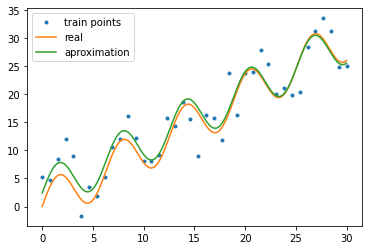

In [3]:
plt.plot(x, Y, '.', label='train points')

x_plot = np.linspace(0, 30, num=10000)
plt.plot(x_plot, 4*np.sin(x_plot) + x_plot, label='real')

X_plot = np.vstack([np.ones_like(x_plot), x_plot, np.sin(x_plot)]).T
plt.plot(x_plot, X_plot@w, label='aproximation')

plt.legend(loc='best')
plt.show()

**Оптимизационная задача для задачи линейной классификации**

Линейная модель бинарной $\{-1, 1\}$ классификации:  
<center>$\mathfrak{F}_{blc}=\{f(\mathbf{w},\mathbf{x}) = sign(\mathbf{w}^T\mathbf{x}) | \mathbf{w} \in \mathbb{R}^n\}$</center>  

Требуется решить следующую оптимизационную задачу:  
<center>$\mathbf{\hat{w}}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\dfrac{1}{l}\sum_{i=1}^{l}{[\mathbf{w}^T\mathbf{x_i}\neq y_i]=\arg\min_{\mathbf{w}\in\mathbb{R}^n}}\dfrac{1}{l}\sum_{i=1}^{l}[y_i\mathbf{w}^T\mathbf{x_i}<0]$</center>  

Но вместо этой задачи оптимизации будем минимизировать верхнюю оценку:  
<center>$\mathbf{\hat{w}}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\dfrac{1}{l}\sum_{i=1}^{l}{log_2(1+e^{-y_i\mathbf{w}^T\mathbf{x_i}})}$</center>  

В данном случае аналитическое решение найти не получится. Будем минимизировать градиентными методами.

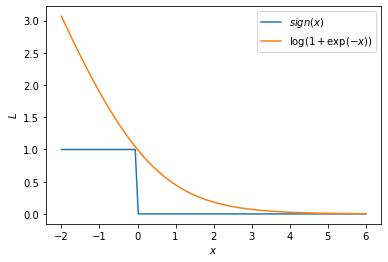

In [4]:
def sign(x):
    return np.array(x <= 0, dtype=np.int64)

def upper_bound(x):
    return np.log2(1+np.exp(-x))


x = np.linspace(-2, 6, 100)
plt.plot(x, sign(x), label='$sign(x)$')
plt.plot(x, upper_bound(x), label='$\log(1+\exp(-x))$')

plt.xlabel('$x$')
plt.ylabel('$L$')
plt.legend(loc='best')
plt.show()

**Стохастический градиентный спуск**

Простой градиентный спуск:  
<center>$\mathbf{w}_k+1=\mathbf{w}_k-\alpha_k\nabla Q(\mathbf{w},\mathbf{X},\mathbf{y})$</center>  

Минусы:  
1. Очень долго считать градиент суммы $Q(\mathbf{w},\mathbf{X},\mathbf{y})=\dfrac{1}{l}\sum_{i=1}^{l}{L(\mathbf{w},\mathbf{x}_i,\mathbf{y}_i)}$;  
2. Маленькая скорость сходимости.  

Рассмотрим стохастический грдиентный спуск:
<center>$\mathbf{w}_{k+1}=\mathbf{w}_k-\alpha_k\nabla L(\mathbf{w},\mathbf{X}_{i_k},y_{i_k})$</center>  

В случае, если индекс объекта $i_k$ сгенерирован равновероятно, то справедливо следующее свойство:  
<center>$E\nabla L(\mathbf{w},\mathbf{x}_{i_k},y_{i_k})=\dfrac{1}{l}\sum_{i=1}^{l}{\nabla L(\mathbf{w},\mathbf{x}_i,y_i)=\nabla Q(\mathbf{w},\mathbf{X},\mathbf{y})}$</center>  

Таким образом, получаем, что в среднем градиент на каждой итерации направлен вдоль истинного градиента.

**Анализ сходимости стохастического градиента**

Рассмотим задачу оптимизации:  
<center>$Q(\mathbf{w})=\dfrac{1}{l}\sum_{i=1}^{l}{L(\mathbf{w},i)}\to\min_\mathbf{w}$,</center>

Где $Q$ является выпуклой функцией по параметру $\mathbf{w}$.

Стохастический градиентный спуск:  
<center>$\mathbf{w}_{k+1}=\mathbf{w}_k-\alpha_k\hat{\mathbf{g}}_k,\quad E\hat{\mathbf{g}}_k=\mathbf{g}_k=\nabla Q(\mathbf{w})$,</center>  

где $\hat{\mathbf{g}}_k$ - градиент на $k$-ом шаге на $i$-ом объекте.

Пусть $\mathbf{w}^*$ - истинный минимум функции $Q$. Рассмотрим норму невязки:  
<center>$\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2=\|\mathbf{w}_k-\mathbf{w}^*-\alpha_k\hat{\mathbf{g}}_k\|^2=\|\mathbf{w}_k-\mathbf{w}^*\|^2-2\alpha_k\hat{\mathbf{g}}_k^T(\mathbf{w}_k-\mathbf{w}^*)+\alpha^2_k\|\hat{\mathbf{g}}_k\|^2$</center>  

Рассмотрим среднее значение невязки при случайном выборе $\hat{\mathbf{g}}_k$:
<center>$E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2=\|\mathbf{w}_k-\mathbf{w}^*\|^2-2\alpha_k\mathbf{g}_k^T(\mathbf{w}_k-\mathbf{w}^*)+\alpha_k^2E\|\hat{\mathbf{g}}_k\|$</center>  

Далее нам потребуется следующая величина:
<center>$\alpha_k\mathbf{g}_k^T(\mathbf{w}_k-\mathbf{w}^*)=\dfrac{1}{2}\|\mathbf{w}_k-\mathbf{w}^*\|^2-\dfrac{1}{2}E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2+\alpha_k^2E\|\hat{\mathbf{g}}_k\|^2$</center>  

В силу выпуклости функции $Q$ справедливо следующее свойство:  
<center>$Q(\mathbf{w}_k)-Q(\mathbf{w}^*)\leq\mathbf{g}_k^T(\mathbf{w}_k-\mathbf{w}^*),\quad\mathbf{g}_k^T=\nabla Q(\mathbf{w})$</center>  

Откуда следует:  
<center>$\mathbf{\alpha}_k(Q(\mathbf{w}_k)-Q(\mathbf{w}^*))\leq\dfrac{1}{2}\|\mathbf{w}_k-\mathbf{w}^*\|^2-\dfrac{1}{2}E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2+\dfrac{\mathbf{\alpha}^2_k}{2}E\|\hat{\mathbf{g}}_k\|^2$</center>  

Далее усредним уже по $\mathbf{g}_k$ для всеъ $k=\overline{1,K}$ и просуммируем $K$ первых итераций:  
<center>$\sum_{k=1}^{K}{\mathbf{\alpha}_k(EQ(\mathbf{w}_k)-Q(\mathbf{w}^*))}\leq\dfrac{1}{2}\|\mathbf{w}_0-\mathbf{w}^*\|^2-\dfrac{1}{2}E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2+\sum_{k=1}^{K}{\dfrac{\mathbf{\alpha}_k^2}{2}E\|\hat{\mathbf{g}}_k\|^2}$</center>  
.  
<center>$\leq\dfrac{1}{2}\|\mathbf{w}_0-\mathbf{w}^*\|^2+\sum_{k=1}^{K}{\dfrac{\mathbf{\alpha}_k^2}{2}E\|\hat{\mathbf{g}}_k\|^2}$</center>  

Воспользуемся неравенством Йенсена для выпуклой функции $Q$:  
<center>$EQ\left(\dfrac{1}{\sum{\mathbf{\alpha}}_k}\sum{\mathbf{\alpha}_k\mathbf{x}_k}\right)-Q(\mathbf{x}^*)\leq\sum_{k=1}^{K}{\mathbf{\alpha}_k(EQ(\mathbf{x}_k)-Q(\mathbf{x}^*))}\leq\dfrac{1}{2}\|\mathbf{x}_0-\mathbf{x}^*\|^2+$</center>  
.  
<center>$+\sum_{k=1}^{K}{\dfrac{\mathbf{\alpha}^2_k}{2}E\|\hat{\mathbf{g}}_k\|^2}$</center>  

Пусть  
<center>$\hat{\mathbf{x}}_K=\dfrac{1}{\sum{\mathbf{\alpha}}_k}\sum{\mathbf{\alpha}_k\mathbf{x}_k},\quad\|\mathbf{x}_0-\mathbf{x}^*\|^2\leq R^2,\quad E\|\hat{\mathbf{g}}_k\|^2\leq G^2$</center>  

Тогда плоучаем следующую оценку:  
<center>$EQ(\hat{\mathbf{x}}_K)-Q(\mathbf{x}^*)\leq\dfrac{R^2+G^2\sum{\mathbf{\alpha}_k^2}}{2\sum{\mathbf{\alpha}_k}}$</center>

**Анализ оценки на скорость сходимости**

Первый способ выбора шага:  
<center>$\sum{\mathbf{\alpha}_k}=\infty, \sum{\mathbf{\alpha}_k^2}\leq\infty,\quad\left[\mathbf{\alpha}_k=\dfrac{1}{k}\right]$</center>  

Получаем скорость сходимсти $\approx O\left(\dfrac{1}{\log{K}}\right)$.  

Второй способ выбора шага:  
<center>$\sum{\mathbf{\alpha}_k}=\infty, \dfrac{\sum{\mathbf{\alpha}_k^2}}{\sum{\mathbf{\alpha}_k}}=0,\quad\left[\mathbf{\alpha}_k=\dfrac{1}{\sqrt{k}}\right]$</center>  

Получаем скорость сходимости $\approx O\left(\dfrac{\log{K}}{\sqrt{k}}\right)$.

Таким образом было получено важное свойство. При константном шаге метод стохастического градиента не сходится.

**2. Возвращение к задаче бинарной классификации**

<center>$\mathbf{\hat{w}}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\dfrac{1}{l}\sum_{i=1}^{l}{log_2(1+e^{-y_i\mathbf{w}^T\mathbf{x_i}})}$</center>

**Генерация синтетической выборки**

In [5]:
torch.manual_seed(0)

l = 1000
n = 2

X = torch.randn([l, n])  # torch-масств размера (l x n)
w_true = torch.randn([n])  # Истинный вектор w
Y = torch.ones([l])
Y[X@w_true < 0] = -1

**Программная реализация градиентнтого спуска**

Первый способ выбора шага: $1/\sqrt{K}$

In [8]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss_sqrt = []
for k in range(1, K+1):
    # Ошибка Q на k-м шаге:
    with torch.no_grad():
        list_of_loss_sqrt.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w))))
        )
    # Выбор случайного элемента из выборки:
    ind = np.random.randint(low=0, high=l)
    alpha = 1/np.sqrt(k)
    # Ошибка на элементе:
    loss = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))
    # g с крышечкой:
    loss.backward()  #  градиент по параметру w (он будет лежать в w.grad)
    # Градиентный шаг:
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)
    # Обнуление градиента:
    w.grad.zero_()  # в w.grad находится градиент dl/dw(wk)

In [9]:
pred = torch.ones([l])
pred[X@w < 0] = -1
print('Точность прогноза: {}'.format(torch.mean((pred == Y).float()).item()))

Точность прогноза: 0.9980000257492065


Второй способ выбора шага: $1/K$

In [10]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss = []
for k in range(1, K+1):
    # Ошибка Q на k-м шаге:
    with torch.no_grad():
        list_of_loss.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w))))
        )
    # Выбор случайного элемента из выборки:
    ind = np.random.randint(low=0, high=l)
    alpha = 1/k
    # Ошибка на элементе:
    loss = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))
    # g с крышечкой:
    loss.backward()  #  градиент по параметру w (он будет лежать в w.grad)
    # Градиентный шаг:
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)
    # Обнуление градиента:
    w.grad.zero_()  # в w.grad находится градиент dl/dw(wk)

In [11]:
pred = torch.ones([l])
pred[X@w < 0] = -1
print('Точность прогноза: {}'.format(torch.mean((pred == Y).float()).item()))

Точность прогноза: 0.9879999756813049


Большое количество методов оптимизации уже реализовано в PyTorch.

In [12]:
torch.manual_seed(0)
w = torch.randn([n], requires_grad=True)

# Датасет:
dataset = torch.utils.data.TensorDataset(X, Y)
generator = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
# Генератор автоматически будет выбирать случайные x и y из выборки.
# batch_size - кол-во объектов, по которым оценивается мат ожидание.
# Данный генератор будет случайным образом выдавать объекты без повторения -
# это является отхождением от классического метода стохастического градиента,
# так как в SG объекты из выборки выбираются с повторениями.

optimizer = torch.optim.SGD([w], lr=1)
# optimizer содержит логику градиентного шага. В данном случае:
# w_{k+1} = w_k - lr*grad,  (lr ~ alpha)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                              lambda k: 1/np.sqrt(k+1))
# scheduler отвечает за обновление lerning rate'а (alpha) в оптимизаторе
# optimizer на каждой итерации.


# ---| Функция обучения |---
list_of_loss_torch = []
for x,y in generator:
    optimizer.zero_grad()  # Обнуление градиентов
    # При применении backward() новые градиенты складываются с предыдущими
    # поэтому важно, чтобы исходные градиенты равнялись нулю.
    
    # Ошибка Q на k-ом шаге:
    with torch.no_grad():
        list_of_loss_torch.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w))))
        )
        
    loss = torch.log2(1+torch.exp(-y*(x@w))).mean()
    loss.backward()
    
    # Шаг оптимизации (w_{k+1} = w_k - lr*grad):
    optimizer.step()
    # Обновление шага:
    scheduler.step()

**Визуализация сходимости**

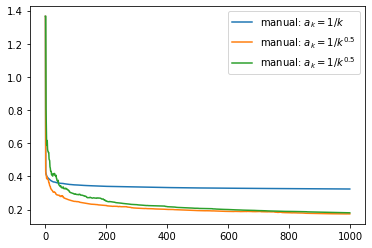

In [13]:
plt.plot(list_of_loss, label='manual: $a_k = 1/k$')
plt.plot(list_of_loss_sqrt, label='manual: $a_k = 1/k^{0.5}$')
plt.plot(list_of_loss_torch, label='manual: $a_k = 1/k^{0.5}$')
plt.legend(loc='best')
plt.show()

Медленная сходимость $1/k$ объясняется тем, что градиентный шаг $\alpha$ очень быстро приближается к нулю.

**3. Вероятностная постановка задачи машинного обучения**

**3.1. Линейная регрессия**

Рассмотрим следующее вероятностное предположение о данных:  
<center>$\mathbf{y}=\mathbf{w}^T\mathbf{x}+\varepsilon,\quad\varepsilon\sim\mathcal{N}(0, \beta)$</center>  

Пусть векторы $\mathbf{w}$ и $\mathbf{x}$ являются не случайными, тогда получаем, что $\mathbf{y}$ является нормальной случайной величиной. Пусть все объекты выборки также являются не зависимыми случайными величинами, тогда получаем правдоподобие выборки:  
<center>$p(\mathbf{y}|\mathbf{w},\mathbf{X})=\prod_{i=1}^{l}{p(y_i|\mathbf{w}, \mathbf{x}_i)}$,</center>  

где $p(y_i|\mathbf{w},\mathbf{x}_i)=\mathcal{N}(\mathbf{w}^T,\mathbf{x}_i,\beta)$.  

Принцип максимума правдоподобия:  
<center>$Q(\mathbf{w},\mathbf{X},\mathbf{y})=-\sum_{i=1}^{l}{\log{p(y_i|\mathbf{w},\mathbf{x}_i)}}=\sum_{i=1}^{l}{\left[\dfrac{\beta}{2}(\mathbf{w}^T\mathbf{x}_i-y_i)^2+C\right]}$</center>  

Данная задача эквивалентна задаче, которая была рассмотрена в начале для линейной регерссии. Решение задачи имеет вид:  
<center>$\hat{\mathbf{w}}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$</center>

**Совместное правдоподобие модели и данных**

Рассмотрим совместное правдоподобие модели и данных:  
<center>$p(\mathbf{y},\mathbf{w}|\mathbf{X})=\prod_{i=1}^{l}{p(y_i|\mathbf{w},\mathbf{x}_i)p(\mathbf{w})}$,</center>  

где для простоты рассмотрим $p(\mathbf{w})=\mathcal{N}(0,\gamma I)$.

По принципу максимума правдоподобия получаем слдующую функцию для минимизации:  
<center>$Q(\mathbf{w},\mathbf{X},\mathbf{y})-\sum_{i=1}^{l}{\log{p(y_i|\mathbf{w},\mathbf{x}_i)}}-\log{p(\mathbf{w})}=\sum_{i=1}^{l}{\left[\dfrac{\beta}{2}(\mathbf{w}^T\mathbf{x}_i-y_i)^2+C_1\right]}+$</center>  
.  
<center>$+\mathbf{w}^T\mathbf{w}+C_2$</center>  

Заметим, что следующая задача оптимизации имеет аналитичесое решение:  
<center>$\hat{\mathbf{w}}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\left\{-\sum_{i=1}^{l}{\log{p(y_i|\mathbf{w},\mathbf{x}_i)}-\log{p(\mathbf{w})}}\right\}=$</center>  
.  
<center>$\arg\min_{\mathbf{w}\in\mathbb{R}^n}{\left\{\sum_{i=1}^{l}{\left[\dfrac{\beta}{2}{(\mathbf{w}^T\mathbf{x}_i-y_i)^2+C_1}\right]}+\dfrac{\gamma}{2}\mathbf{w}^T\mathbf{w}+C_2\right\}}$</center>

**Задание**  
Найти аналитическое решение для задачи минимизации выше

**3.2. Логистическая регрессия**

Рассмотрим следующее вероятностное предположение о данных:  
<center>$y\sim Be(\sigma(\mathbf{w}^T\mathbf{x})),\quad\sigma(x)=\dfrac{1}{1+\exp(-x)}$</center>

Принцип максимума правдоподобия:
<center>$
\begin{equation*}
    Q(\mathbf{w},\mathbf{X},\mathbf{y})=
    -\sum_{i=1}^{l}{
        \log{
            p(y_i|\mathbf{w},\mathbf{w}_i)
        }
    }=
\end{equation*}
$</center>
.
<center>$
\begin{equation*}
    =
    \sum_{i=1}^{l}{
        \left[
            y_i\log{\sigma(\mathbf{w}^T\mathbf{w}_i)}+
            (1-y_i)\log{(1-\sigma(\mathbf{w}^T\mathbf{x}_i))}+
            C
        \right]
    }
\end{equation*}
$</center>

Аналогично рассмотрим совместное правдоподобие модели и данных. ЗАпишем правдоподобие в случае, когда $p(\mathbf{w})=\mathcal{N}(0, \gamma I)$:
<center>$
\begin{equation*}
    Q(\mathbf{w},\mathbf{X},\mathbf{y})=
    -\sum_{i=1}^{l}{
        \log{p(y_i|\mathbf{w},\mathbf{x}_i)}
    }-
    \log{p(\mathbf{w})}=
\end{equation*}
$</center>
.
<center>$
    =\sum_{i=1}^{l}{
        \left[
            y_i\log{\sigma(\mathbf{w}^T,\mathbf{x}_i)}+
            (1-y_i)\log{(1-\sigma(\mathbf{w}^T\mathbf{x}_i))+
            C_1}
        \right]
    }+
    \dfrac{\gamma}{2}\mathbf{w}^T\mathbf{w}+C_2
$</center>

**Анализ решения задачи оптимизации от параметра $\mathbf{\gamma}$**

Заметим, что решение оптимизационной задачи зависит от параметра $\gamma$:
<center>$
    \hat{\mathbf{w}}(\gamma)=
    \arg\min_{\mathbf{w}\in\mathbb{R}^n}{
        \left\{
            \sum_{i=1}^{l}{
                \left[
                    y_i\log{\sigma\left(\mathbf{w}^T\mathbf{x}_i\right)}+
                    (1-y_i)\log{\left(1-\sigma\left(
                        \mathbf{w}^T,\mathbf{x}_i
                    \right)\right)}
                \right]+
                \dfrac{\gamma}{2}\mathbf{w}^T\mathbf{w}
            }
        \right\}
    }
$</center>

Рассмотрим решение логистической регрессии для разных параметров $\gamma$.

In [89]:
# Синтетическая выборка
np.random.seed(0)
l = 50000
n = 2

X = np.random.randn(l, n)
w = np.random.randn(n)
Y = np.random.binomial(n=1, p=expit(X@w))

In [ ]:
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]

models_l2 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l2', C=2/gamma, fit_intercept=False, 
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l2[gamma] = model
    
models_l1 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l1', C=2/gamma, fit_intercept=False, 
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l1[gamma] = model

In [ ]:
x = [models_l2[gamma].coef_[0][0] for gamma in models_l2]
y = [models_l2[gamma].coef_[0][1] for gamma in models_l2]

plt.plot(x, y, 'bo')
plt.plot(x, y, 'b-', linewidth=1, label='l2 penalty')

x = [models_l1[gamma].coef_[0][0] for gamma in models_l1]
y = [models_l1[gamma].coef_[0][1] for gamma in models_l1]

plt.plot(x, y, 'go')
plt.plot(x, y, 'g-', linewidth=1, label='l1 penalty')

plt.scatter(w[0], w[1], marker='*', c='r', label='true w')
plt.legend(loc='best')
plt.show()